In [15]:
"""Stochastic Neighbor Embedding"""
import numpy as np 
from matplotlib import pyplot as plt 

from mnist.tools import *

In [16]:
# load data
images, labels = load_data()
images, labels = images[:50], labels[:50]

In [17]:
sigma = 1 # to determine

In [18]:
# 1. compute the similarity matrix in high-dimension P
N = len(images)
n, m = images[0].shape
P = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            P[i,j] = np.exp(1/(m*n)*np.sum((images[i] - images[j])**2)/(2*sigma))
# normalize rows
P/=np.sum(P, axis=0)[:,None]

In [154]:
def compute_P(X, goal_perp=10):
    N = len(X)
    n, m = X[0].shape
    P = np.zeros((N, N))
    sigmas = np.ones(N)*50
    for i in range(N):
        delta = 50
        while True:
            for j in range(N):
                if i != j:
                    P[i,j] = np.exp(1/(m*n)*np.sum((X[i] - X[j])**2)/(2*sigmas[i]))
            # normalize
            P[i, :] = P[i, :] / np.sum(P[i, :] )
            perp = compute_perplexity(P[i,:])
            if np.abs(perp - goal_perp) < 1:
                break
            elif perp  > goal_perp:
                sigmas[i] = sigmas[i] - delta/2
            else:
                sigmas[i] = sigmas[i] + delta/2
            delta /= 2
    return P, sigmas


In [155]:
def compute_perplexity(p):
    N = len(p)
    x = p * np.log2(p)
    x = x[~np.isnan(x)]  # filter out nan
    H = -np.sum(x)
    return 2**H

In [156]:
# 2. initialize Y in 2 dimensions
Y = np.random.rand(N, 2)

In [157]:
# 3. Compute the similarity matrix in low-dimension Q
def compute_Q(Y):
    N, _ = Y.shape
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                Q[i,j] = np.exp(np.sum((Y[i] - Y[j])**2))
    # normalize rows
    Q /= np.sum(Q, axis=0)[:,None]
    return Q

In [159]:
# 4. Compute gradients
grads = np.zeros((N, 2))
for i in range(N):
    for j in range(N):
        grads[i, :] += 2*(P[i, j] - Q[i, j] + P[j, i] - Q[j, i])*(Y[i,:]-Y[j,:])

TypeError: tuple indices must be integers or slices, not tuple

In [25]:
def compute_grads(Y, P, Q):
    grads = np.zeros((N, 2))
    for i in range(N):
        for j in range(N):
            grads[i, :] += 2*(P[i, j] - Q[i, j] + P[j, i] - Q[j, i])*(Y[i,:]-Y[j,:])
    return grads
    

In [26]:
# 4b. initialize 
zeta = 0.1
alpha = 0
Y_prev = Y

In [27]:
# 5. update Y
Y_new = Y + zeta * grads + alpha * (Y - Y_prev)
Y_prev = Y
Y = Y_new

In [167]:
# Everything together: iterative procedure
# load data
N = 100
images, labels = load_data()
images, labels = images[:N], labels[:N]
# 1. Compute P
P, _ = compute_P(images)
# 2. Initialize Y in 2 dimensions
Y = np.random.rand(N, 2)
zeta = 0.001     # learning rate
alpha = 0.1      # momentum term
eps = 5e-3       # convergence threshold
Y_prev = np.zeros_like(Y)


diff, ii = 10, 0
while diff > eps:
    # 3. Compute Q
    Q = compute_Q(Y)
    # 4. Compute gradients
    grads = compute_grads(Y, P, Q)
    # 5. Perform gradient descent step
    diff = np.linalg.norm(Y - Y_prev)
    if ii > 0 and ii % 10 == 0:
        print(f"{ii}: {diff:9.8f}, alpha={alpha:5.4f}")
    Y_new = Y + zeta * grads + alpha * (Y - Y_prev)
    Y_prev = Y
    Y = Y_new
    ii += 1
    alpha *= 0.999
    


10: 0.07743251, alpha=0.0990
20: 0.05725085, alpha=0.0980
30: 0.02177681, alpha=0.0970
40: 0.02090841, alpha=0.0961
50: 0.01977876, alpha=0.0951
60: 0.01869261, alpha=0.0942
70: 0.01784887, alpha=0.0932
80: 0.01721193, alpha=0.0923
90: 0.01666463, alpha=0.0914
100: 0.01612750, alpha=0.0905
110: 0.01557326, alpha=0.0896
120: 0.01500699, alpha=0.0887
130: 0.01444685, alpha=0.0878
140: 0.01390949, alpha=0.0869
150: 0.01340282, alpha=0.0861
160: 0.01292657, alpha=0.0852
170: 0.01247695, alpha=0.0844
180: 0.01205059, alpha=0.0835
190: 0.01164584, alpha=0.0827
200: 0.01126243, alpha=0.0819
210: 0.01090054, alpha=0.0810
220: 0.01056022, alpha=0.0802
230: 0.01024111, alpha=0.0794
240: 0.00994255, alpha=0.0787
250: 0.00966365, alpha=0.0779
260: 0.00940338, alpha=0.0771
270: 0.00916070, alpha=0.0763
280: 0.00893455, alpha=0.0756
290: 0.00872395, alpha=0.0748
300: 0.00852800, alpha=0.0741
310: 0.00834587, alpha=0.0733
320: 0.00817686, alpha=0.0726
330: 0.00802035, alpha=0.0719
340: 0.00787583, al

In [162]:
def plot_Y(Y, labels):
    plt.figure(figsize=(12, 12))
    for label in set(labels):
        idxs = np.where(np.array(labels) == label)[0]
        plt.scatter(Y[idxs, 0], Y[idxs, 1], label=label)
    plt.legend()
    plt.show()

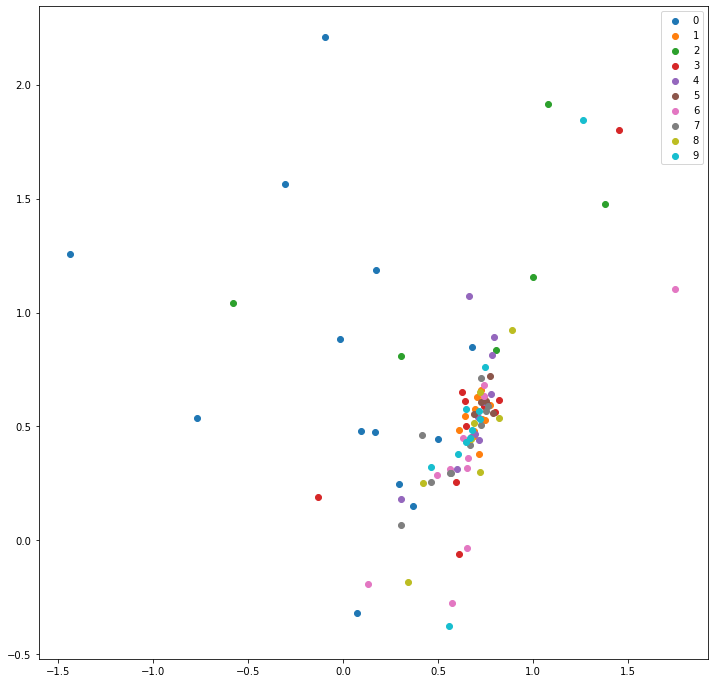

In [168]:
plot_Y(Y, labels)